In [2]:
#initialization 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx
import numpy as np

from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

#importing qiskit
import qiskit
from qiskit import IBMQ, Aer, assemble, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Operator
from qiskit.circuit import Parameter, ParameterVector
from qiskit.optimization import QuadraticProgram

#import basic plot tools
from qiskit.visualization import plot_histogram, plot_state_city


In [3]:
def quadratic_program_from_graph(graph: nx.Graph) -> QuadraticProgram:
    '''Constructs a QuadraticProblem from a given graph for a MAXCUT instance.
    Args:
        graph: UNderlying graph of the problem
    Returns: 
        QuadraticProblem
    '''
    # get weight matrix from the graph
    weight_matrix = nx.adjacency_matrix(graph)
    shape = weight_matrix.shape
    size = shape[0]
    # build QUBO matrix Q from weight matrix
    qubo_matrix = np.zeros((size, size))
    qubo_vector = np.zeros(size)
    for i in range(size):
        for j in range(size):
            qubo_matrix[i,j] -= weight_matrix[i, j]
            qubo_vector[i] += weight_matrix[i,j]
    # define the quadraric program
    quadratic_program = QuadraticProgram('maxcut')
    for i in range(size):
        var_name = 'x_{}'.format(i)
        quadratic_program.binary_var(var_name)
    quadratic_program.maximize(quadratic=qubo_matrix, linear=qubo_vector, constant=0)
    #print(quadratic_program.export_as_lp_string())
    return quadratic_program

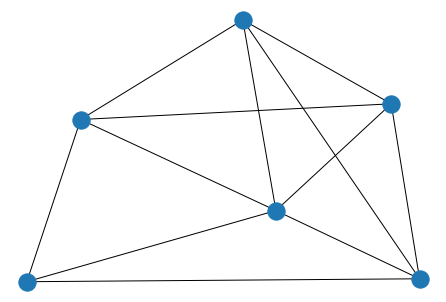

In [4]:
import networkx as nx

graph = nx.Graph()
# add nodes and edges
graph.add_nodes_from(np.arange(0,6,1))
edges = [(0,1,2.0), (0,2,3.0), (0,4,4.0), (0,5,1.0), (1,2,4.0), (1,3,1.0), (1,4,1.0), (1,5,3.0), (2,4,2.0), (2,5,3.0), (3,4,5.0), (3,5,1.0)]
graph.add_weighted_edges_from(edges)
nx.draw(graph)

In [5]:
qpx = quadratic_program_from_graph(graph)
print(qpx.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: maxcut

Maximize
 obj: 10 x_0 + 11 x_1 + 12 x_2 + 7 x_3 + 12 x_4 + 8 x_5 + [ - 8 x_0*x_1
      - 12 x_0*x_2 - 16 x_0*x_4 - 4 x_0*x_5 - 16 x_1*x_2 - 4 x_1*x_3 - 4 x_1*x_4
      - 12 x_1*x_5 - 8 x_2*x_4 - 12 x_2*x_5 - 20 x_3*x_4 - 4 x_3*x_5 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



In [6]:
qp = quadratic_program_from_graph(graph)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: maxcut

Maximize
 obj: 10 x_0 + 11 x_1 + 12 x_2 + 7 x_3 + 12 x_4 + 8 x_5 + [ - 8 x_0*x_1
      - 12 x_0*x_2 - 16 x_0*x_4 - 4 x_0*x_5 - 16 x_1*x_2 - 4 x_1*x_3 - 4 x_1*x_4
      - 12 x_1*x_5 - 8 x_2*x_4 - 12 x_2*x_5 - 20 x_3*x_4 - 4 x_3*x_5 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



In [7]:
from qiskit.aqua.algorithms import QAOA
from qiskit.optimization.algorithms import admm_optimizer

#size = qp.get_num_vars()
#operator, _ = qp.to_ising()
#p = 1 # depth of the ansatz 


In [71]:
def qaoa_circuit(qubo: QuadraticProgram, gammas, betas, p: int = 1):
    '''
    Given a QUBO instance and the number of layers, construct 
    a corresponding parametrized circuit with p layers.
    Args:
        qubo: The quadratic qubo instance
        p: The number of layers in the QAOA circuit
    Returns: 
        The parametrized QAOA circuit
    '''
    size = len(qubo.variables)
    qubo_matrix = qubo.objective.quadratic.to_array(symmetric=True)
    qubo_linearity = qubo.objective.linear.to_array()

    # Prepare the quantum and classical registers
    qaoa_circuit = QuantumCircuit(size, size)
    # Apply the initial layer of Hadamard gates to all qubits
    qaoa_circuit.h(range(size))

    # Create the parameters to be used in the circuit
    #gammas = ParameterVector('gamma', p)
    #betas = ParameterVector('beta', p)

    # Outer loop to create eahc layer
    for layer in range(p):
        # Apply Rz rotational gates from the cost layer
        for i in range(size):
            w_i = (qubo_linearity[layer] + sum(qubo_matrix[i])) / 2
            qaoa_circuit.rz(phi=gammas[layer]*w_i, qubit=i)
        # Apply the Rzz rotational gates for entangled qubits from cost layer
        for i in range(1,size):
            for j in range(i):
                w_ij = qubo_matrix[i,j]/4
                qaoa_circuit.rzz(theta=gammas[layer]*w_ij, qubit1=i, qubit2=j)
        # Apply single qubit Rx rotations from mixer layer to all qubits
        qaoa_circuit.barrier()
        for i in range(size):
            qaoa_circuit.rx(theta=2*betas[layer], qubit=i)

    # Measure the result in computational basis
    qaoa_circuit.barrier()
    qaoa_circuit.measure(range(size), range(size))

    return qaoa_circuit

In [79]:
p = 1
qp = quadratic_program_from_graph(graph)
gammas = ParameterVector('gamma', p)
betas = ParameterVector('beta', p)
qc = qaoa_circuit(qp, gammas, betas)
#qc.draw(fold=-1)

In [83]:
# assign parameters using assign_parameters method
param_dict = {gammas : [np.random.random()], betas: [np.random.random()]}
new_circuit = qc.assign_parameters(param_dict=param_dict)
#new_circuit.draw(fold=-1)
#print(new_circuit.parameters)

In [100]:
simulator = Aer.get_backend('statevector_simulator')

transpiled_qc = transpile(new_circuit, simulator)
obj = assemble(transpiled_qc, shots=512)
result = simulator.run(obj).result()
print(result.get_counts())
v = max(result.get_counts())
print(v)
print(qp.objective.quadratic.to_array())
#plot_histogram(result.get_counts())

{'100110': 1}
100110
[[  0.  -4.  -6.   0.  -8.  -2.]
 [  0.   0.  -8.  -2.  -2.  -6.]
 [  0.   0.   0.   0.  -4.  -6.]
 [  0.   0.   0.   0. -10.  -2.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]]


In [23]:
from qiskit.aqua.algorithms import QAOA
from qiskit.optimization.algorithms import MinimumEigenOptimizer

backend = Aer.get_backend('statevector_simulator')
qaoa = QAOA(quantum_instance=backend, initial_point=[10.0, 0.0])
eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver=qaoa)
qp = quadratic_program_from_graph(graph)
result = eigen_optimizer.solve(qp)
print(result.samples)
print(result)

[('101100', 23.0, 0.015625000000000007), ('010011', 23.0, 0.015625000000000007), ('110100', 22.0, 0.015625000000000007), ('001011', 22.0, 0.015625000000000007), ('010010', 21.0, 0.015625000000000007), ('011010', 21.0, 0.015625000000000007), ('100101', 21.0, 0.015625000000000007), ('101101', 21.0, 0.015625000000000007), ('011100', 20.0, 0.015625000000000007), ('111100', 20.0, 0.015625000000000007), ('001010', 20.0, 0.015625000000000007), ('110101', 20.0, 0.015625000000000007), ('000011', 20.0, 0.015625000000000007), ('100011', 20.0, 0.015625000000000007), ('001100', 19.0, 0.015625000000000007), ('110010', 19.0, 0.015625000000000007), ('001101', 19.0, 0.015625000000000007), ('110011', 19.0, 0.015625000000000007), ('110000', 17.0, 0.015625000000000007), ('100100', 17.0, 0.015625000000000007), ('001110', 17.0, 0.015625000000000007), ('110001', 17.0, 0.015625000000000007), ('011011', 17.0, 0.015625000000000007), ('001111', 17.0, 0.015625000000000007), ('101000', 16.0, 0.015625000000000007),

In [22]:
def plot_samples(samples):
    '''Plots a bar diagramm for the samples of a quantum algorithm
        Args: 
            samples
    '''
    # Sort samles by probability
    samples = sorted(samples, key = lambda x: x[2])
    # Get list of probabilities, function values and bitstrings
    probabilities = [sample[2] for sample in samples]
    values = [sample[1] for sample in samples]
    bitstrings = [''.join([str(int(i)) for i in sample[0]]) for sample in samples]
    # Plot the bar diagramm
    sample_plot = go.Bar(x=bitstrings, y=probabilities, marker=dict(color=values, colorscale='plasma', colorbar=dict(title='Function Value')))
    fig = go.Figure(    
        data=sample_plot
    )
    fig.show()

plot_samples(result.samples)


Text(0.5, 0.92, 'surface')

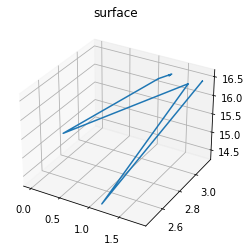

In [47]:
graph_name = 'custom'
quadratic_program = quadratic_program_from_graph(graph)

trajectory={'beta_0':[], 'gamma_0':[], 'energy':[]}
offset = 1/4*quadratic_program.objective.quadratic.to_array(symmetric  = True).sum() + 1/2*quadratic_program.objective.linear.to_array().sum()
def callback(eval_count, params, mean, std_dev):
    trajectory['beta_0'].append(params[1])
    trajectory['gamma_0'].append(params[0])
    trajectory['energy'].append(-mean + offset)

qaoa = QAOA(quantum_instance = backend, initial_point = [6.2,1.8],callback = callback)
eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)
result = eigen_optimizer.solve(quadratic_program)

x = np.array(trajectory['beta_0'])
y = np.array(trajectory['gamma_0'])
z = np.array(trajectory['energy'])
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z)
ax.set_title('surface')